# Toxicity - Argument Quality Timeseries Analysis

In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
tqdm.tqdm.pandas()
sns.set(style="whitegrid", font_scale=1.5, font="Times New Roman")

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [4]:
full_df = tasks.postprocessing.get_main_dataset()
full_df

,conv_id,message_id,message_order,conv_variant,model,user,user_prompt,is_moderator,intent,message,Toxicity,Argument Quality,not_intervened
0,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",2,4,False
1,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,5,False
2,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
3,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",3,4,False
4,75173c9d-9d25-4389-93d9-6fd7978e30b8,-263216810755555070,1,No Instructions,hardcoded,CryptoBro89,You are a human participating in an online cha...,False,Troll,"In other words, he’s not brown enough for ya t...",4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57470,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57471,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57472,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False
57473,8e301e72-344d-4331-89bc-4dc1edca20fe,1901685793557660101,21,Constr. Comms,Qwen 2.5,moderator,You are a human participating in an online cha...,True,Moderator,"Thank you, @ReclusivePoet31, for sharing that ...",1,1,False


In [5]:
no_hardocoded_df = full_df[full_df.model != "hardcoded"]

In [6]:
no_mod_df = no_hardocoded_df.copy()
no_mod_df = no_mod_df[~no_mod_df.is_moderator]
contains_mod = no_mod_df.conv_variant != "No Moderator"
no_mod_df.loc[contains_mod, "message_order"] = (
    no_mod_df[contains_mod].message_order // 2 + 1
)

## Timeseries analysis

### Role

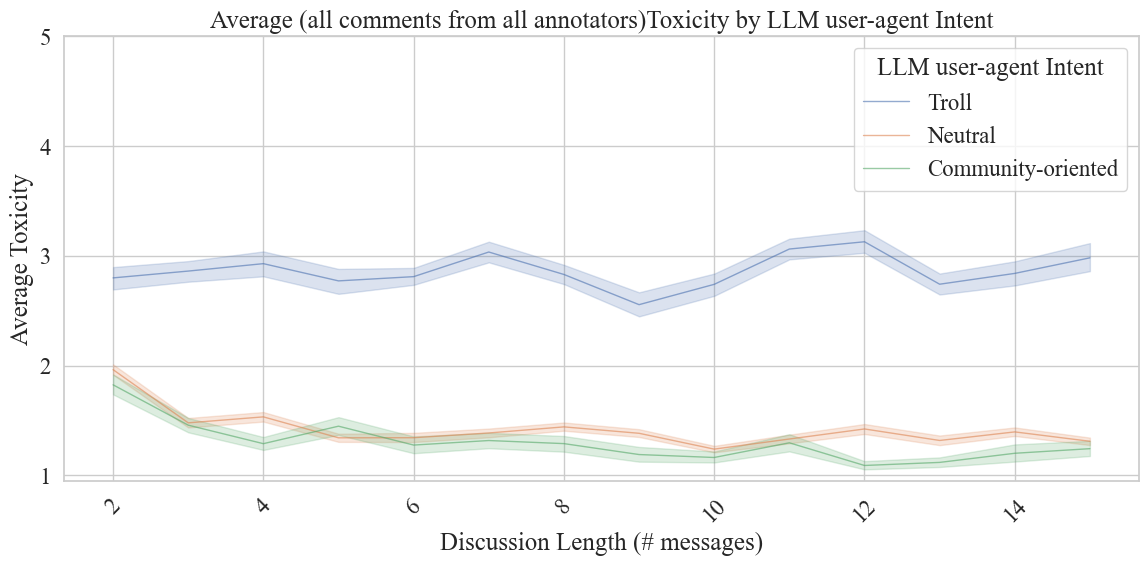

In [7]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

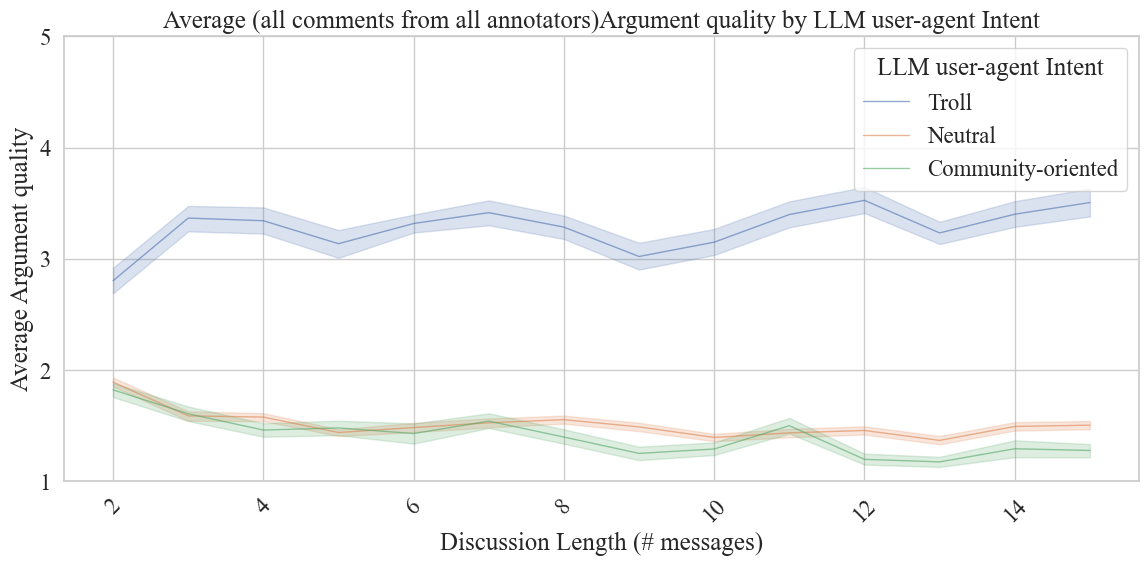

In [8]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="intent",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Moderation Strategy

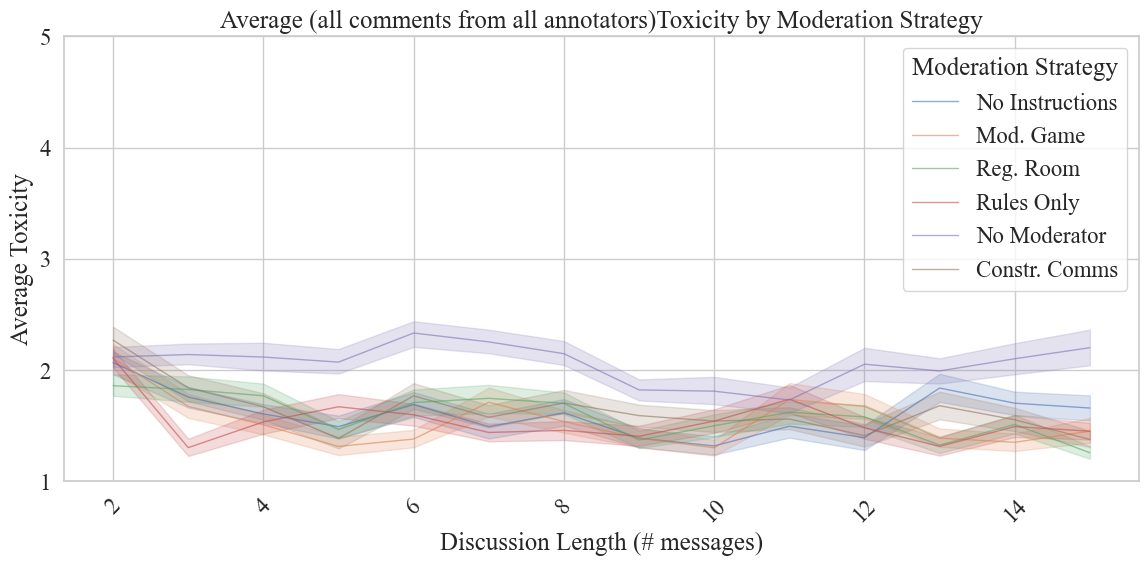

In [9]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

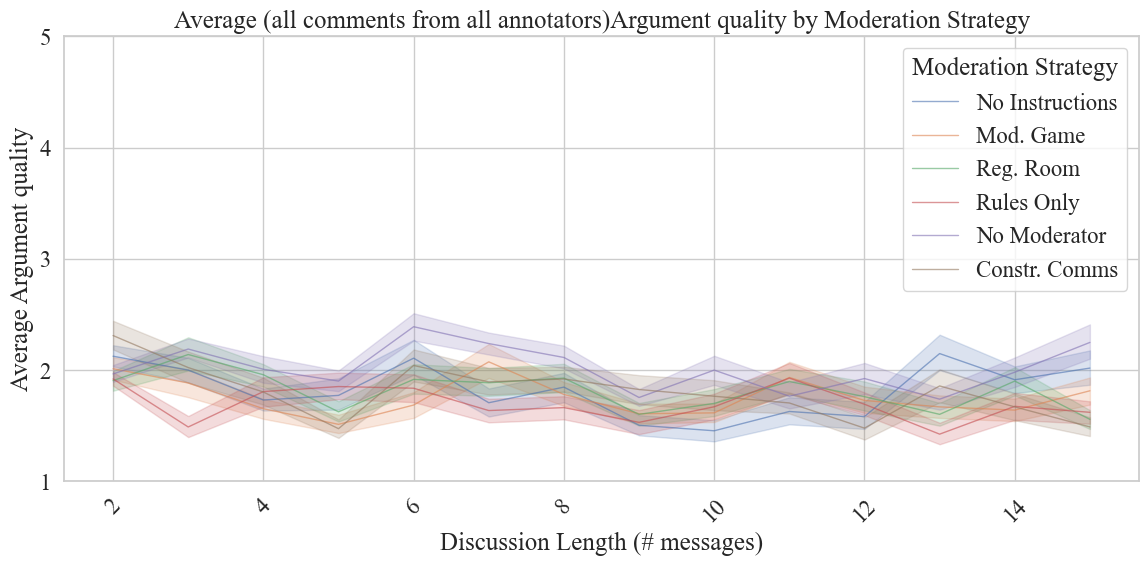

In [10]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="conv_variant",
    hue_col_label="Moderation Strategy",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

### Models

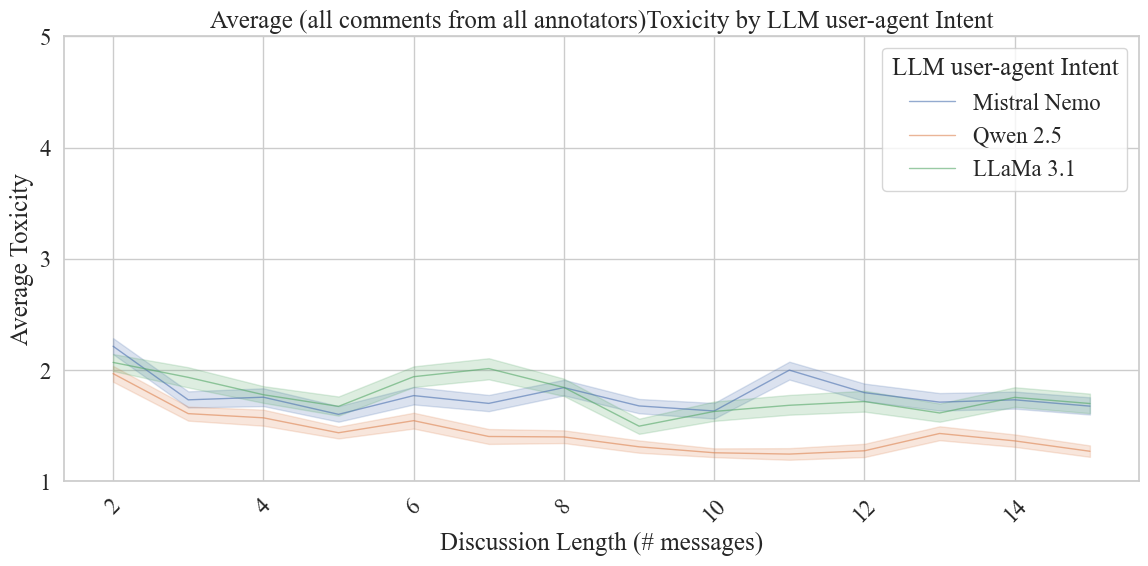

In [11]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Toxicity",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

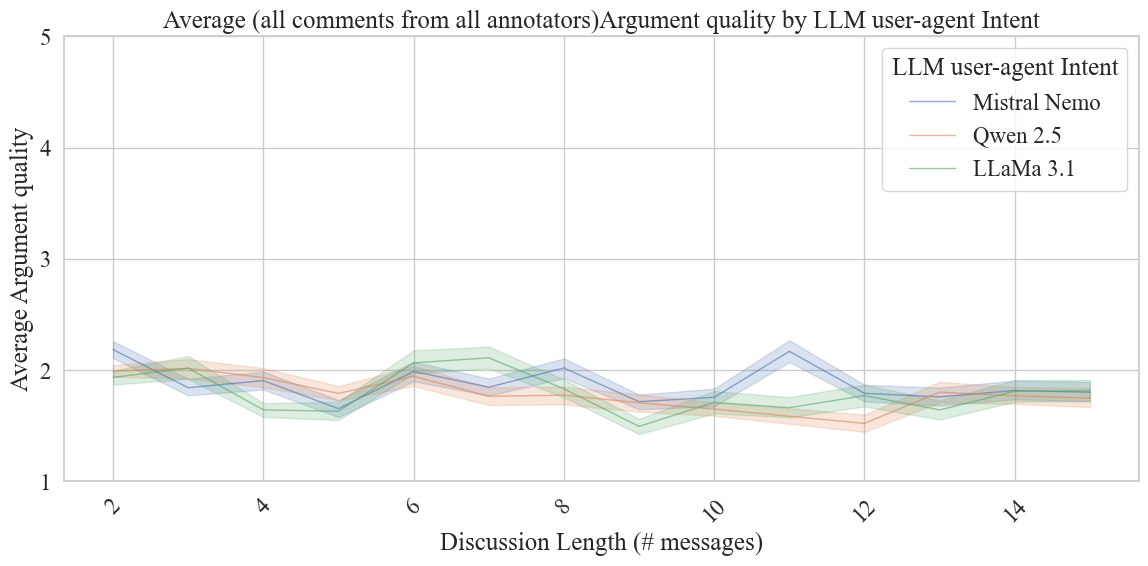

In [12]:
tasks.graphs.plot_timeseries(
    no_mod_df,
    y_col="Argument Quality",
    hue_col="model",
    hue_col_label="LLM user-agent Intent",
)
plt.yticks(TOXICITY_TICKS)
plt.show()

## Statistics

In [13]:
model = smf.ols(
    "Toxicity ~ C(conv_variant, Treatment(reference='No Moderator'))*message_order",
    data=no_mod_df
)

# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Toxicity   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     113.1
Date:                Mon, 19 May 2025   Prob (F-statistic):          1.37e-252
Time:                        13:18:23   Log-Likelihood:                -27554.
No. Observations:               21494   AIC:                         5.513e+04
Df Residuals:                   21482   BIC:                         5.523e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 2.1635      0.034     64.515      0.000       2.098       2.229
C(conv_variant, Treatment(reference='No Moderator'))[T.Constr. Comms]                    -0.2302      0.048     -4.838      0.000      -0.323      -0.137
C(conv_variant, Treatment(reference='No Moderator'))[T.Mod. Game]                        -0.4348      0.048     -8.975      0.000      -0.530      -0.340
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]                  -0.4258      0.048     -8.894      0.000      -0.520      -0.332
C(conv_variant, Treatment(reference='No Moderator'))[T.Reg. Room]                        -0.2767      0.047     -5.835      0.000      -0.370      -0.184
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]                       -0.4609      0.047     -9.719      0.000      -0.554      -0.368
message_order                                                                            -0.0118      0.004     -3.299      0.001      -0.019      -0.005
C(conv_variant, Treatment(reference='No Moderator'))[T.Constr. Comms]:message_order      -0.0230      0.005     -4.521      0.000      -0.033      -0.013
C(conv_variant, Treatment(reference='No Moderator'))[T.Mod. Game]:message_order          -0.0107      0.005     -2.082      0.037      -0.021      -0.001
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]:message_order    -0.0033      0.005     -0.637      0.524      -0.013       0.007
C(conv_variant, Treatment(reference='No Moderator'))[T.Reg. Room]:message_order          -0.0232      0.005     -4.599      0.000      -0.033      -0.013
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]:message_order         -0.0076      0.005     -1.498      0.134      -0.017       0.002
==============================================================================
Omnibus:                     3508.602   Durbin-Watson:                   0.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5478.391
Skew:                           1.180   Prob(JB):                         0.00
Kurtosis:                       3.737   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
model = smf.ols(
    "arg_quality ~ C(conv_variant, Treatment(reference='No Moderator'))*message_order",
    data=no_mod_df.rename({"Argument Quality": "arg_quality"}, axis=1),
)

# Fit the model
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            arg_quality   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     33.07
Date:                Mon, 19 May 2025   Prob (F-statistic):           1.27e-70
Time:                        13:18:23   Log-Likelihood:                -29766.
No. Observations:               21494   AIC:                         5.956e+04
Df Residuals:                   21482   BIC:                         5.965e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================================
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                 2.1126      0.037     56.836      0.000       2.040       2.185
C(conv_variant, Treatment(reference='No Moderator'))[T.Constr. Comms]                    -0.0066      0.053     -0.126      0.900      -0.110       0.097
C(conv_variant, Treatment(reference='No Moderator'))[T.Mod. Game]                        -0.2815      0.054     -5.241      0.000      -0.387      -0.176
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]                  -0.2135      0.053     -4.022      0.000      -0.317      -0.109
C(conv_variant, Treatment(reference='No Moderator'))[T.Reg. Room]                        -0.1065      0.053     -2.025      0.043      -0.210      -0.003
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]                       -0.3045      0.053     -5.793      0.000      -0.408      -0.201
message_order                                                                            -0.0115      0.004     -2.909      0.004      -0.019      -0.004
C(conv_variant, Treatment(reference='No Moderator'))[T.Constr. Comms]:message_order      -0.0240      0.006     -4.242      0.000      -0.035      -0.013
C(conv_variant, Treatment(reference='No Moderator'))[T.Mod. Game]:message_order           0.0029      0.006      0.509      0.611      -0.008       0.014
C(conv_variant, Treatment(reference='No Moderator'))[T.No Instructions]:message_order     0.0027      0.006      0.474      0.635      -0.008       0.014
C(conv_variant, Treatment(reference='No Moderator'))[T.Reg. Room]:message_order          -0.0112      0.006     -1.992      0.046      -0.022      -0.000
C(conv_variant, Treatment(reference='No Moderator'))[T.Rules Only]:message_order         -0.0017      0.006     -0.296      0.767      -0.013       0.009
==============================================================================
Omnibus:                     4374.879   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7769.919
Skew:                           1.318   Prob(JB):                         0.00
Kurtosis:                       4.316   Cond. No.                         149.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""